# Remote Subset Example

## Objectives
1. <a href="#find">Find the latest latest available output from the High Resolution Rapid Refresh (HRRR)</a>
1. <a href="#grid">Subset the dataset for a single variable by specifying time and a latitude/longitude bounding box.</a>
1. <a href="#point">Extract time series data from a single latitude/longitude</a>

<a name="find"></a>
Let's get the latest available output from the HRRR.

In [1]:
from siphon.catalog import TDSCatalog
cat = TDSCatalog('http://thredds.ucar.edu/thredds/catalog/'
                 'grib/NCEP/GFS/Global_0p25deg/catalog.xml')

In [2]:
latest_dataset = cat.latest

In [3]:
latest_dataset

GFS_Global_0p25deg_20180109_1200.grib2

<a name="grid"></a>
Let's get things setup for making a subset request. It's not as simple as "accessing" a remote file, but it's really not bad.

In [4]:
ncss = latest_dataset.subset()
query = ncss.query()

Ok, what variables are available?

In [5]:
ncss.variables

{'5-Wave_Geopotential_Height_isobaric',
 'Absolute_vorticity_isobaric',
 'Albedo_surface_Mixed_intervals_Average',
 'Apparent_temperature_height_above_ground',
 'Best_4_layer_Lifted_Index_surface',
 'Categorical_Freezing_Rain_surface_Mixed_intervals_Average',
 'Categorical_Ice_Pellets_surface_Mixed_intervals_Average',
 'Categorical_Rain_surface_Mixed_intervals_Average',
 'Categorical_Snow_surface_Mixed_intervals_Average',
 'Cloud_Work_Function_entire_atmosphere_single_layer_Mixed_intervals_Average',
 'Cloud_mixing_ratio_isobaric',
 'Cloud_water_entire_atmosphere_single_layer',
 'Convective_Precipitation_Rate_surface_Mixed_intervals_Average',
 'Convective_available_potential_energy_pressure_difference_layer',
 'Convective_available_potential_energy_surface',
 'Convective_inhibition_pressure_difference_layer',
 'Convective_inhibition_surface',
 'Convective_precipitation_surface_Mixed_intervals_Accumulation',
 'Dewpoint_temperature_height_above_ground',
 'Downward_Long-Wave_Radp_Flux_surf

Let's work with `Temperature_height_above_ground`:

In [6]:
query.variables('Temperature_height_above_ground')

var=Temperature_height_above_ground

Let's request a small spatial subset from our global dataset:

In [7]:
query.lonlat_box(east=-80, west=-90, south=35, north=45)

var=Temperature_height_above_ground&west=-90&east=-80&south=35&north=45

Let's request the 12 hours of data, starting with the time closest to now:

In [8]:
from datetime import datetime, timedelta
now = datetime.now()

In [9]:
query.time(now + timedelta(hours=12))

var=Temperature_height_above_ground&time=2018-01-10T02%3A21%3A24.359950&west=-90&east=-80&south=35&north=45

Finally, let's ask for the subset to be returned as a `netCDF-4` file:

In [10]:
query.accept('netcdf4')

var=Temperature_height_above_ground&time=2018-01-10T02%3A21%3A24.359950&west=-90&east=-80&south=35&north=45&accept=netcdf4

Now we can actually contact the server and ask for the data:

In [11]:
nc = ncss.get_data(query)

In [12]:
nc.variables

OrderedDict([('Temperature_height_above_ground',
              <class 'netCDF4._netCDF4.Variable'>
              float32 Temperature_height_above_ground(time1, height_above_ground4, lat, lon)
                  long_name: Temperature @ Specified height level above ground
                  units: K
                  abbreviation: TMP
                  missing_value: nan
                  grid_mapping: LatLon_Projection
                  coordinates: time1 height_above_ground4 lat lon 
                  Grib_Variable_Id: VAR_0-0-0_L103
                  Grib2_Parameter: [0 0 0]
                  Grib2_Parameter_Discipline: Meteorological products
                  Grib2_Parameter_Category: Temperature
                  Grib2_Parameter_Name: Temperature
                  Grib2_Level_Type: 103
                  Grib2_Level_Desc: Specified height level above ground
                  Grib2_Generating_Process_Type: Forecast
              unlimited dimensions: 
              current shape = (1,

Let's take a quick peek!

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

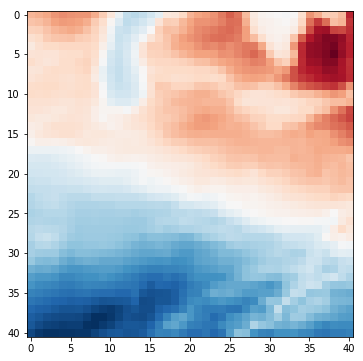

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(nc.variables['Temperature_height_above_ground'][0,0,::], cmap='RdBu')

<a name="point"></a>
Let's reuse our query object to make a request for a two day forecast at a specific grid point, keeping everything else the same:

In [15]:
query.lonlat_point(lon=-105, lat=40)
query.time_range(now, now + timedelta(days=2))

var=Temperature_height_above_ground&time_start=2018-01-09T14%3A21%3A24.359950&time_end=2018-01-11T14%3A21%3A24.359950&longitude=-105&latitude=40&accept=netcdf4

Again, let's make the request for the data and take a peek!

In [16]:
nc = ncss.get_data(query)
temp_data = nc.variables['Temperature_height_above_ground'][:]
times = nc.variables['time'][:]

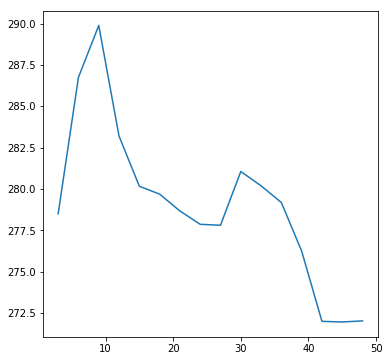

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(times[0], temp_data[0,:,0])
